In [29]:
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss
from torch.distributions import Normal

import math
import time

from utils import *
from plot_utils import *
#from utils import plot_s
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [30]:
# model and flow parameters
hidden_dim = 32
width= 64
t0 = 0  # flow start time
t1 = 1  # flow end time

# optimization parameters
lr= 3e-3

In [31]:
# model
cnf= CNF(in_out_dim=2, hidden_dim=hidden_dim, width=width).to(device)
print(cnf)
ts= torch.tensor([t1, t0]).type(torch.float32).to(device)# for training, we flow the samples backward (in time)


CNF(
  (net): HyperNetwork(
    (fc1): Linear(in_features=1, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=32, bias=True)
    (fc3): Linear(in_features=32, out_features=448, bias=True)
  )
)


In [32]:
def prior():
    return Normal(
        loc=torch.zeros(2),
        scale=torch.ones(2),
    )
p_z0 = torch.distributions.MultivariateNormal(
    loc=torch.tensor([0.0, 0.0]).to(device),
    covariance_matrix=torch.tensor([[0.1, 0.0], [0.0, 0.1]]).to(device)
)

In [33]:
_csv='/Users/ssa195/Downloads/dt8122-2022-main/datasets/two_moons.csv'
_data=Dataset2D(csv_file=_csv)
train_dataloader, test_dataloader = get_train_test_loader(_csv)
num_batches = train_dataloader.__len__()
#plot_samples(train_dataloader)

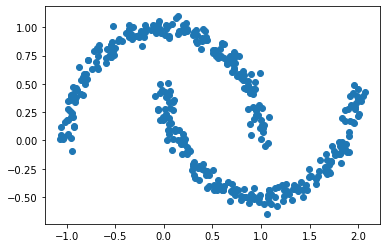

In [34]:
#plot training data
tr=None
for x,y,data in train_dataloader:
    #print(x.shape)
    if tr is not None:
        tr=torch.cat((tr,data),dim=0)
    else:
        tr=data.clone()
    

plt.scatter(tr[:,0],tr[:,1] )

In [ ]:
start= time.time()

#Training
optimizer = torch.optim.Adam(cnf.parameters(), lr=lr)

epochs = 1000  # 300

print('Training...')
cnf = cnf.train()
a = 0
z0 = []

for epoch in range(1, epochs):
    loss_sum = 0.0
    for i, (x,y,data) in enumerate(train_dataloader):
        data = data.type(torch.FloatTensor).to(device)
        x1 = data
        optimizer.zero_grad()
        a += x1.size()[0]
        # initialize initial densities
        logp_diff_t1 = torch.zeros(x1.size()[0], 1).type(torch.float32).to(device)

        # compute the backward solutions
        z_t, logp_diff_t = cnf(ts, x1, logp_diff_t1)  # outputs time first
        z_t0, logp_diff_t0 = z_t[-1], logp_diff_t[-1]
        z0.append(z_t0.detach().cpu())

        # compute the density of each sample
        logp_x = p_z0.log_prob(z_t0).to(device) - logp_diff_t0  # .view(-1)
        loss = -logp_x.mean(0)
        loss.sum().backward()
        optimizer.step()
        loss_sum += loss.sum().detach().cpu().item()

    if epoch % 1 == 0:
        print('Epoch: {}/{}, Loss: {:.3f}'.format(epoch, epochs, loss_sum / len(train_dataloader)))
    
    if epoch % 5 == 0:
        torch.save(cnf, '/Users/ssa195/Downloads/dt8122-2022-main/cnf_trained_2moons/model.pt')
cnf = cnf.eval()

end = time.time()
print('Training finished in: ', (end - start) / 60, 'minutes')


Training...
Epoch: 1/1000, Loss: 155.230
Epoch: 2/1000, Loss: 69.607
Epoch: 3/1000, Loss: 57.208
Epoch: 4/1000, Loss: 52.799
Epoch: 5/1000, Loss: 49.264
Epoch: 6/1000, Loss: 47.807
Epoch: 7/1000, Loss: 46.697
Epoch: 8/1000, Loss: 45.593
Epoch: 9/1000, Loss: 44.524
Epoch: 10/1000, Loss: 43.011
Epoch: 11/1000, Loss: 41.066
Epoch: 12/1000, Loss: 39.041
Epoch: 13/1000, Loss: 38.053
Epoch: 14/1000, Loss: 37.068
Epoch: 15/1000, Loss: 34.562
Epoch: 16/1000, Loss: 33.980
Epoch: 17/1000, Loss: 31.168
Epoch: 18/1000, Loss: 29.168
Epoch: 19/1000, Loss: 26.702
Epoch: 20/1000, Loss: 25.196
Epoch: 21/1000, Loss: 24.226
Epoch: 22/1000, Loss: 23.950
Epoch: 23/1000, Loss: 22.297
Epoch: 24/1000, Loss: 20.926
Epoch: 25/1000, Loss: 21.070
Epoch: 26/1000, Loss: 21.361
Epoch: 27/1000, Loss: 19.757
Epoch: 28/1000, Loss: 21.531
Epoch: 29/1000, Loss: 17.970
Epoch: 30/1000, Loss: 17.469
Epoch: 31/1000, Loss: 18.693
Epoch: 32/1000, Loss: 18.633
Epoch: 33/1000, Loss: 16.102
Epoch: 34/1000, Loss: 14.745
Epoch: 35/

Epoch: 283/1000, Loss: 7.349
Epoch: 284/1000, Loss: 6.939
Epoch: 285/1000, Loss: 7.081
Epoch: 286/1000, Loss: 6.678
Epoch: 287/1000, Loss: 8.155
Epoch: 288/1000, Loss: 11.136
Epoch: 289/1000, Loss: 7.782
Epoch: 290/1000, Loss: 6.954
Epoch: 291/1000, Loss: 6.410
Epoch: 292/1000, Loss: 6.719
Epoch: 293/1000, Loss: 6.642
Epoch: 294/1000, Loss: 6.982
Epoch: 295/1000, Loss: 9.296
Epoch: 296/1000, Loss: 6.798
Epoch: 297/1000, Loss: 6.148
Epoch: 298/1000, Loss: 6.699
Epoch: 299/1000, Loss: 7.306
Epoch: 300/1000, Loss: 8.773
Epoch: 301/1000, Loss: 7.227
Epoch: 302/1000, Loss: 6.820
Epoch: 303/1000, Loss: 6.440
Epoch: 304/1000, Loss: 6.501
Epoch: 305/1000, Loss: 8.250
Epoch: 306/1000, Loss: 7.250
Epoch: 307/1000, Loss: 7.018
Epoch: 308/1000, Loss: 7.555
Epoch: 309/1000, Loss: 6.166
Epoch: 310/1000, Loss: 6.067
Epoch: 311/1000, Loss: 5.516
Epoch: 312/1000, Loss: 6.080
Epoch: 313/1000, Loss: 5.592
Epoch: 314/1000, Loss: 6.768
Epoch: 315/1000, Loss: 5.379
Epoch: 316/1000, Loss: 6.213
Epoch: 317/10

Epoch: 566/1000, Loss: 3.266
Epoch: 567/1000, Loss: 5.887
Epoch: 568/1000, Loss: 6.068
Epoch: 569/1000, Loss: 4.239
Epoch: 570/1000, Loss: 3.482
Epoch: 571/1000, Loss: 4.709
Epoch: 572/1000, Loss: 4.245
Epoch: 573/1000, Loss: 3.933
Epoch: 574/1000, Loss: 2.810
Epoch: 575/1000, Loss: 2.671
Epoch: 576/1000, Loss: 2.604
Epoch: 577/1000, Loss: 2.498
Epoch: 578/1000, Loss: 3.194
Epoch: 579/1000, Loss: 3.525
Epoch: 580/1000, Loss: 2.903
Epoch: 581/1000, Loss: 3.907
Epoch: 582/1000, Loss: 1.646
Epoch: 583/1000, Loss: 2.752
Epoch: 584/1000, Loss: 1.280
Epoch: 585/1000, Loss: 2.285
Epoch: 586/1000, Loss: 3.354
Epoch: 587/1000, Loss: 3.053
Epoch: 588/1000, Loss: 2.420
Epoch: 589/1000, Loss: 2.293
Epoch: 590/1000, Loss: 1.375
Epoch: 591/1000, Loss: 3.462
Epoch: 592/1000, Loss: 3.536
Epoch: 593/1000, Loss: 1.590
Epoch: 594/1000, Loss: 4.918
Epoch: 595/1000, Loss: 6.717
Epoch: 596/1000, Loss: 7.923
Epoch: 597/1000, Loss: 5.508
Epoch: 598/1000, Loss: 5.408
Epoch: 599/1000, Loss: 2.395
Epoch: 600/100

Epoch: 849/1000, Loss: -0.386
Epoch: 850/1000, Loss: -0.924
Epoch: 851/1000, Loss: -0.532
Epoch: 852/1000, Loss: -0.425
Epoch: 853/1000, Loss: 0.491
Epoch: 854/1000, Loss: -0.589
Epoch: 855/1000, Loss: -1.134
Epoch: 856/1000, Loss: -0.096
Epoch: 857/1000, Loss: 1.748


In [ ]:
torch.save(cnf, '/Users/ssa195/Downloads/dt8122-2022-main/cnf_trained_2moons/model.pt')

In [ ]:
trained_cnf=torch.load('/Users/ssa195/Downloads/dt8122-2022-main/cnf_trained_2moons/model.pt')
trained_cnf = trained_cnf.eval()

In [ ]:
d=None
for x,y,data in test_dataloader:
    #print(x.shape)
    if d is not None:
        d=torch.cat((d,data),dim=0)
    else:
        d=data.clone()
    

plt.scatter(d[:,0],d[:,1] )

In [ ]:
def plot_cnf_animation(target_sample, t0, t1, viz_timesteps, p_z0, z_t1, z_t_samples, z_t_density, logp_diff_t,img_path):
    

    for (t, z_sample, z_density, logp_diff) in zip(
            np.linspace(t0, t1, viz_timesteps),
            z_t_samples, z_t_density, logp_diff_t):
        fig = plt.figure(figsize=(12, 4), dpi=200)
        plt.tight_layout()
        plt.axis('off')
        plt.margins(0, 0)
        fig.suptitle(f'{t:.2f}s')

        ax1 = fig.add_subplot(1, 3, 1)
        ax1.set_title('Target')
        ax1.get_xaxis().set_ticks([])
        ax1.get_yaxis().set_ticks([])
        ax2 = fig.add_subplot(1, 3, 2)
        ax2.set_title('Samples')
        ax2.get_xaxis().set_ticks([])
        ax2.get_yaxis().set_ticks([])
        ax3 = fig.add_subplot(1, 3, 3)
        ax3.set_title('Log Probability')
        ax3.get_xaxis().set_ticks([])
        ax3.get_yaxis().set_ticks([])

        ax1.hist2d(*target_sample.detach().cpu().numpy().T, bins=300, density=True,
                   range=[[-2, 2.5], [-2, 2.5]])
        #ax1.scatter(*target_sample.detach().cpu().numpy().T)
        ax2.hist2d(*z_sample.detach().cpu().numpy().T, bins=300, density=True,
                   range=[[-2, 2.5], [-2, 2.5]])
        #ax2.scatter(*z_sample.detach().cpu().numpy().T)
        logp = p_z0.log_prob(z_density) - logp_diff.view(-1)
        ax3.tricontourf(*z_t1.detach().cpu().numpy().T,
                        np.exp(logp.detach().cpu().numpy()), 200)

        plt.savefig(os.path.join(img_path, f"cnf-viz-{int(t*1000):05d}.jpg"),
                   pad_inches=0.2, bbox_inches='tight')
        plt.close()

    imgs = [Image.open(f) for f in sorted(glob.glob(os.path.join(img_path, f"cnf-viz-*.jpg")))]

    fig = plt.figure(figsize=(18,6))
    ax  = fig.gca()
    img = ax.imshow(imgs[0])

    def animate(i):
        img.set_data(imgs[i])
        return img,

    anim = animation.FuncAnimation(fig, animate, frames=41, interval=200)
    plt.close()
    return anim

In [ ]:
#!pip install ipython
from IPython import display
# samples
viz_samples   = d.shape[0]
viz_timesteps = 41

t0 = 0  # flow start time
t1 = 1  # flow end time

# simulate the flow
with torch.no_grad():
    # Generate evolution of samples
    z_t0 = p_z0.sample([viz_samples])
    logp_diff_t0 = torch.zeros(viz_samples, 1).type(torch.float32)

    ts = torch.tensor(np.linspace(t0, t1, viz_timesteps))
    z_t_samples, _  = trained_cnf(ts, z_t0, logp_diff_t0)

    # Generate evolution of density
    x = np.linspace(-2, 2.5, 100)
    y = np.linspace(-2, 2.5, 100)
    points = np.vstack(np.meshgrid(x, y)).reshape([2, -1]).T
    
    z_t1 = torch.tensor(points).type(torch.float32)
    logp_diff_t1 = torch.zeros(z_t1.shape[0], 1).type(torch.float32)
    ts = torch.tensor(np.linspace(t1, t0, viz_timesteps))
    z_t_density, logp_diff_t = trained_cnf(ts, z_t1, logp_diff_t1)
    
img_path = os.path.join('/Users/ssa195/Downloads/dt8122-2022-main/cnf_trained_2moons/')
anim = plot_cnf_animation(d, t0, t1, viz_timesteps, p_z0, z_t1, z_t_samples, z_t_density, logp_diff_t,img_path)
display.HTML(anim.to_jshtml())

In [ ]:
#function to create and save gif from saved images
def make_gif(frame_folder,gif_name):
    frames = [Image.open(image) for image in sorted(glob.glob(f"{frame_folder}/*.jpg"))]
    print(len(frames))
    frame_one = frames[0]
    frame_one.save(gif_name, append_images=frames,
               save_all=True, duration=100, loop=0)

In [ ]:
#create and save gif from saved cnf images
make_gif("/Users/ssa195/Downloads/dt8122-2022-main/cnf_trained_2moons",'/Users/ssa195/Downloads/dt8122-2022-main/cnf_trained_2moons/cnf_2moons.gif')